In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load packages

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile
import tensorflow_addons as tfa

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### parameters

In [5]:
dataset = "cifar10"
labels_per_class = 4 # 'full'
n_latent_dims = 1024
confidence_threshold = 0.8 # minimum confidence to include in UMAP graph for learned metric
learned_metric = True # whether to use a learned metric, or Euclidean distance between datapoints

augmented = True #
min_dist= 0.001 # min_dist parameter for UMAP
negative_sample_rate = 5 # how many negative samples per positive sample 
batch_size = 128 # batch size 
optimizer = tf.keras.optimizers.Adam(1e-3) # the optimizer to train
optimizer = tfa.optimizers.MovingAverage(optimizer)
label_smoothing = 0.2 # how much label smoothing to apply to categorical crossentropy
max_umap_iterations = 50 # how many times, maximum, to recompute UMAP
max_epochs_per_graph = 50 # how many epochs maximum each graph trains for (without early stopping)
umap_patience = 5 # how long before recomputing UMAP graph

In [22]:
from datetime import datetime

datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = (
    str(dataset)
    + "_"
    + str(confidence_threshold)
    + "_"
    + str(labels_per_class)
    + "____"
    + datestring 
    + '_umap_augmented'
)
print(datestring)

cifar10_0.8_4____2020_08_18_10_25_52_015723_umap_augmented


#### Load dataset

In [6]:
from tfumap.semisupervised_keras import load_dataset

In [7]:
(
    X_train,
    X_test,
    X_labeled,
    Y_labeled,
    Y_masked,
    X_valid,
    Y_train,
    Y_test,
    Y_valid,
    Y_valid_one_hot,
    Y_labeled_one_hot,
    num_classes,
    dims
) = load_dataset(dataset, labels_per_class)

### load architecture

In [8]:
from tfumap.semisupervised_keras import load_architecture

In [9]:
encoder, classifier, embedder = load_architecture(dataset, n_latent_dims)

### load pretrained weights

In [10]:
from tfumap.semisupervised_keras import load_pretrained_weights

In [11]:
encoder, classifier = load_pretrained_weights(dataset, augmented, labels_per_class, encoder, classifier)

W0817 22:54:49.578285 139758149252864 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow_addons.layers.wrappers.WeightNormalization object at 0x7f1af69e3940> and <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7f1af69e3e10>).
W0817 22:54:49.580625 139758149252864 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow_addons.layers.wrappers.WeightNormalization object at 0x7f1af6a42eb8> and <tensorflow.python.keras.layers.advanced_activations.

W0817 22:54:49.793952 139758149252864 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow_addons.layers.wrappers.WeightNormalization object at 0x7f1af69b5128> and <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f1af69b5320>).
W0817 22:54:49.803726 139758149252864 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f1af69b5320> and <tensorflow.python.keras.layers.adv

#### compute pretrained accuracy

In [12]:
# test current acc
pretrained_predictions = classifier.predict(encoder.predict(X_test, verbose=True), verbose=True)
pretrained_predictions = np.argmax(pretrained_predictions, axis=1)
pretrained_acc = np.mean(pretrained_predictions == Y_test)
print('pretrained acc: {}'.format(pretrained_acc))

  1/313 [..............................] - ETA: 0s

W0817 22:54:53.249435 139758149252864 callbacks.py:328] Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0074s vs `on_predict_batch_end` time: 0.0155s). Check your callbacks.


313/313 [==============================] - 0s 2ms/step
pretrained acc: 0.2814


### get a, b parameters for embeddings

In [13]:
from tfumap.semisupervised_keras import find_a_b

In [14]:
a_param, b_param = find_a_b(min_dist=min_dist)

### build network

In [15]:
from tfumap.semisupervised_keras import build_model

In [16]:
model = build_model(
    batch_size=batch_size,
    a_param=a_param,
    b_param=b_param,
    dims=dims,
    encoder=encoder,
    classifier=classifier,
    negative_sample_rate=negative_sample_rate,
    optimizer=optimizer,
    label_smoothing=label_smoothing,
    embedder = embedder,
)

### build labeled iterator

In [17]:
from tfumap.semisupervised_keras import build_labeled_iterator

In [18]:
labeled_dataset = build_labeled_iterator(X_labeled, Y_labeled_one_hot, augmented, dims)

### training

In [19]:
from livelossplot import PlotLossesKerasTF
from tfumap.semisupervised_keras import get_edge_dataset
from tfumap.semisupervised_keras import zip_datasets

#### callbacks

In [20]:
# early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_classifier_acc', min_delta=0, patience=15, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

# plot losses callback
groups = {'acccuracy': ['classifier_accuracy', 'val_classifier_accuracy'], 'loss': ['classifier_loss', 'val_classifier_loss']}
plotlosses = PlotLossesKerasTF(groups=groups)

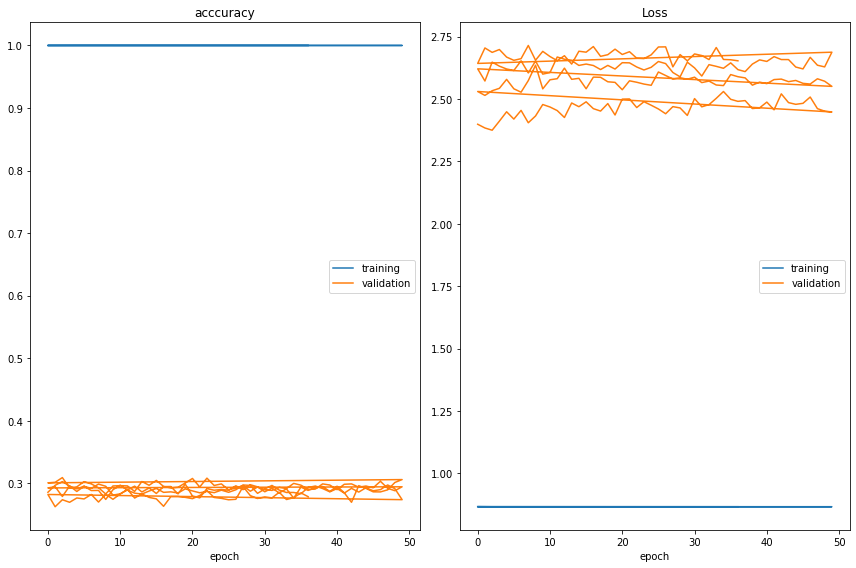

acccuracy
	training         	 (min:    1.000, max:    1.000, cur:    1.000)
	validation       	 (min:    0.263, max:    0.309, cur:    0.279)
Loss
	training         	 (min:    0.867, max:    0.867, cur:    0.867)
	validation       	 (min:    2.375, max:    2.714, cur:    2.653)
312/312 [==============================] - 218s 697ms/step - loss: 1.0753 - classifier_loss: 0.8670 - umap_loss: 0.2083 - classifier_accuracy: 1.0000 - val_loss: 2.6526 - val_classifier_loss: 2.6526 - val_umap_loss: 0.0000e+00 - val_classifier_accuracy: 0.2787
Epoch 38/50
138/312 [============>.................] - ETA: 1:48 - loss: 1.0779 - classifier_loss: 0.8670 - umap_loss: 0.2110 - classifier_accuracy: 1.0000

KeyboardInterrupt: 

In [21]:
history_list = []
current_validation_acc = 0
batches_per_epoch = np.floor(len(X_train)/batch_size).astype(int)
epochs_since_last_improvement = 0
for current_umap_iterations in tqdm(np.arange(max_umap_iterations)):
    
    # make dataset
    edge_dataset = get_edge_dataset(
        model,
        classifier,
        encoder,
        X_train,
        Y_masked,
        batch_size,
        confidence_threshold,
        labeled_dataset,
        dims,
        learned_metric = learned_metric
    )
    
    # zip dataset
    zipped_ds = zip_datasets(labeled_dataset, edge_dataset, batch_size)
    
    # train dataset
    history = model.fit(
        zipped_ds,
        epochs=max_epochs_per_graph,
        validation_data=(
            (X_valid, tf.zeros_like(X_valid), tf.zeros_like(X_valid)),
            {"classifier": Y_valid_one_hot},
        ),
        callbacks = [early_stopping, plotlosses],
        max_queue_size = 100,
        steps_per_epoch = batches_per_epoch,
        #verbose=0
    )
    history_list.append(history)
    # get validation acc
    pred_valid = classifier.predict(encoder.predict(X_valid))
    new_validation_acc = np.mean(np.argmax(pred_valid, axis = 1) == Y_valid)
    
    # if validation accuracy has gone up, mark the improvement
    if new_validation_acc > current_validation_acc:
        epochs_since_last_improvement = 0
        current_validation_acc = copy.deepcopy(new_validation_acc)
    else:
        epochs_since_last_improvement += 1
        
    if epochs_since_last_improvement > umap_patience:
        print('No improvement in {} UMAP iterators'.format(umap_patience))
        break

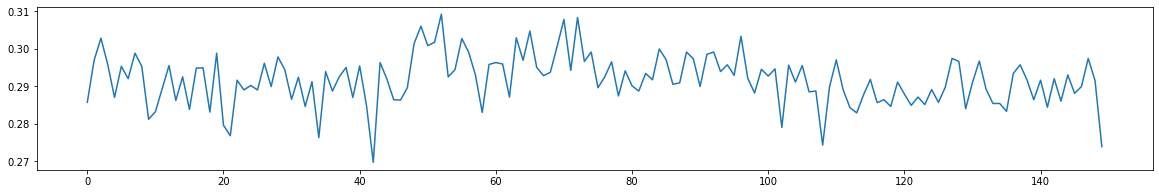

In [23]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(np.concatenate([i.history['val_classifier_accuracy'] for i in history_list]))

## Save results

In [24]:
from tfumap.paths import MODEL_DIR, ensure_dir

In [25]:
save_folder = MODEL_DIR / 'semisupervised-keras' / dataset / str(labels_per_class) / datestring
ensure_dir(save_folder)

### save weights

In [26]:
encoder.save_weights((save_folder / "encoder").as_posix())

In [27]:
classifier.save_weights((save_folder / "classifier").as_posix())

### save score

In [28]:
class_pred = classifier.predict(encoder.predict(X_test))
class_acc = np.mean(np.argmax(class_pred, axis=1) == Y_test)
print(class_acc)

0.2808


In [29]:
np.save(save_folder / 'test_loss.npy', (np.nan, class_acc))

### save embedding

In [30]:
z = encoder.predict(X_train)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 18 10:26:43 2020 Finding Nearest Neighbors
Tue Aug 18 10:26:43 2020 Building RP forest with 15 trees
Tue Aug 18 10:26:43 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
Tue Aug 18 10:26:55 2020 Finished Nearest Neighbor Search
Tue Aug 18 10:26:57 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Aug 18 10:27:22 2020 Finished embedding


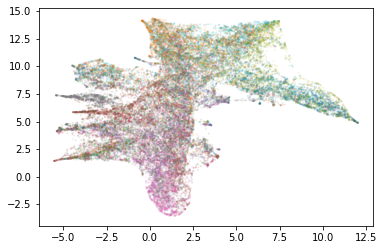

In [31]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

In [32]:
np.save(save_folder / 'train_embedding.npy', embedding)

### save history

In [33]:
import pickle

In [34]:
with open(save_folder / 'history.pickle', 'wb') as file_pi:
    pickle.dump([i.history for i in history_list], file_pi)

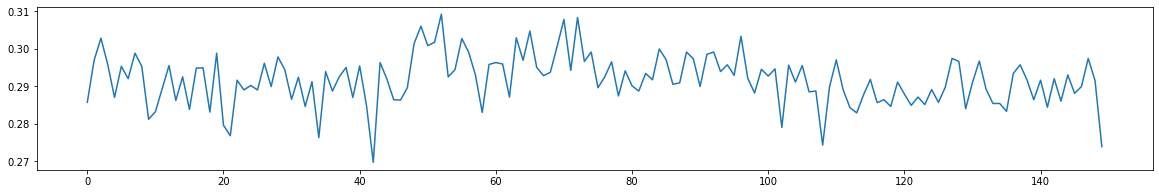

In [35]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(np.concatenate([i.history['val_classifier_accuracy'] for i in history_list]))